In [1]:
import pandas as pd

In [2]:
import re

In [3]:
import glob

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [5]:
import matplotlib.dates as dates

In [6]:
import matplotlib.pyplot as plt

In [7]:
import matplotlib.ticker as ticker

In [8]:
%matplotlib inline

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [301]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

### Load the texts

Open the files and load the speech into a dataframe

In [9]:
filenames = glob.glob("docs/*.txt.cleaned1.final")

In [10]:
lagebeurteilungen = []

In [11]:
for file in filenames:
    current = {}
    with open(file, 'r') as f:
        text = f.read()
    current['file'] = re.split('/', file)[-1]
    current['text'] = text
    lagebeurteilungen.append(current)

In [12]:
df = pd.DataFrame(lagebeurteilungen)

In [13]:
df['date'] = pd.to_datetime(df['file'].str.extract(r'(\d{8})'), format='%Y%m%d')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [14]:
df = df.set_index('date')

In [15]:
df['year'] = df.index.year

In [16]:
# We start at 2002, when every quarter is available
df = df['2002':]

In [17]:
df.head(2)

,file,text,year
date,,,
2002-03-21,pre_20020321.de.pdf.txt.cleaned1.final,"Die Nationalbank hat beschlossen, ihre gegenwä...",2002
2002-06-14,pre_20020614.de.pdf.txt.cleaned1.final,Die Schweizerische Nationalbank hat beschlosse...,2002


### Stop words

In [25]:
with open('wordlists/partikelpronomen.txt', 'r') as f:
    partikel = re.split('\n', f.read())

In [27]:
with open('wordlists/verben.txt', 'r') as f:
    verben = re.split('\n', f.read())

In [28]:
with open('wordlists/partikel2.txt', 'r') as f:
    partikel2 = re.split('\n', f.read())

In [31]:
with open('wordlists/stopwords_129.txt', 'r') as f:
    stopwords_129 = re.split('\n', f.read())

In [29]:
with open('wordlists/stopwords_596.txt', 'r') as f:
    stopwords_596 = re.split('\n', f.read())

In [30]:
with open('wordlists/stopwords_1852.txt', 'r') as f:
    stopwords_1852 = re.split('\n', f.read())

### Length of the text

In [18]:
def get_length(row):
    return len(row['text'])
df['length'] = df.apply(get_length, axis=1)

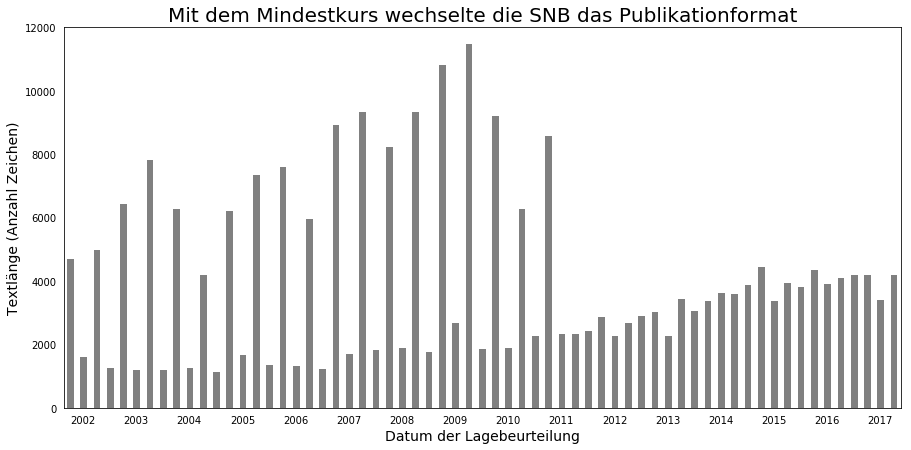

In [354]:
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes

df.plot(y='length', x='year', figsize=(15,7), ax=ax, linewidth=4, kind='bar', color="grey")
ax.set_title("Mit dem Mindestkurs wechselte die SNB das Publikationformat", fontsize=20)
ax.set_ylim([0, 12000])   
ax.set_ylabel('Textlänge (Anzahl Zeichen)', fontsize=14)
ax.yaxis.set_ticks_position('none')
ax.set_xlabel("Datum der Lagebeurteilung", fontsize=14)
#ax.xaxis.set_major_locator(dates.YearLocator())
#fig.autofmt_xdate()
#ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
ax.xaxis.set_ticks_position('none')
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0, ha='left')
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 4 != 0:
        label.set_visible(False)
#ax.legend(fontsize=14, borderpad=1, loc=2)
ax.legend().set_visible(False)
ax.grid(False)

plt.savefig('web/img/textlength.pdf')

## Similarity

### Some stopwords

In [161]:
vec = CountVectorizer(stop_words=stopwords_596)
matrix = vec.fit_transform(df.text)
features_df = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())
features_df.head(2)

,00,10,100,11,13,135,14,145,15,16,...,übertragen,übertragung,übertrug,überwiegen,überwälzt,überwälzung,üblich,üblicherweise,übrige,übrigen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
#most frequent words
features_df.sum().sort_values(ascending=False).head(10)

nationalbank          516
dreimonats            204
libor                 198
quartal               190
wachstum              165
jahr                  144
25                    144
inflationsprognose    143
inflation             134
prognose              129
dtype: int64

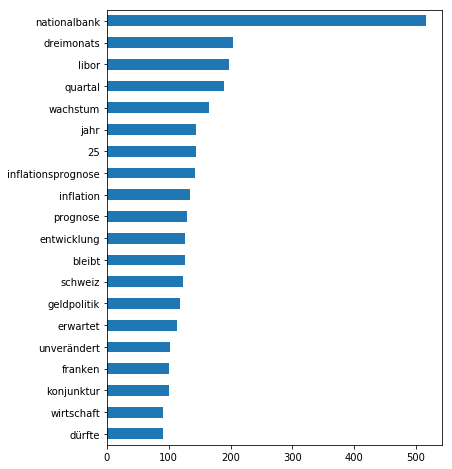

In [163]:
features_df.sum().sort_values(ascending=False).head(20).sort_values().plot(kind="barh", figsize=(6,8))

In [164]:
similarity = cosine_similarity(features_df)

In [165]:
similarity_df = pd.DataFrame(similarity, columns=df.index, index=df.index)

In [166]:
df['similarity'] = 0
for i, date in enumerate(df.index):
    if i > 0:
        df.loc[date, 'similarity'] = similarity[i][i-1]

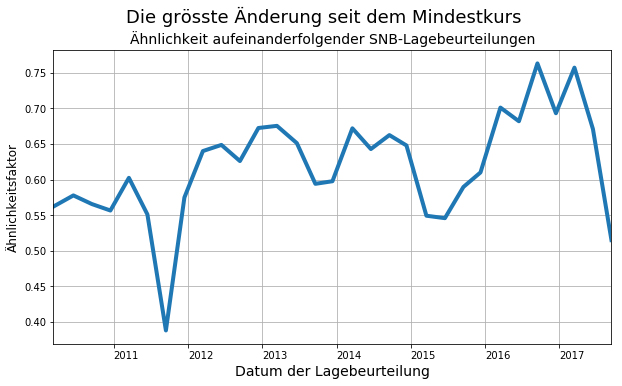

In [393]:
ax = df['2010':].similarity.plot(figsize=(10,6), linewidth=4)
#ax.set_title("Das unähnlichste SNB-Statement seit dem Mindestkurs", fontsize=20)
plt.suptitle("Die grösste Änderung seit dem Mindestkurs", y=0.98, fontsize=18)
plt.title("Ähnlichkeit aufeinanderfolgender SNB-Lagebeurteilungen", fontsize=14)
ax.set_ylabel("Ähnlichkeitsfaktor", fontsize=12)
ax.set_xlabel("Datum der Lagebeurteilung", fontsize=14)
ax.xaxis.set_major_locator(dates.YearLocator())
#ax.legend(fontsize=12, borderpad=1, loc=2)
ax.legend().set_visible(False)
ax.grid(True)
plt.xticks(rotation=0)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
plt.savefig('web/img/similarity.pdf')

## Tracking particular words

In [281]:
vec = CountVectorizer()
matrix = vec.fit_transform(df.text)
features_df = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names(), index=df.index)
features_df.head(2)

,00,10,100,11,13,135,14,145,15,16,...,übertragen,übertragung,übertrug,überwiegen,überwälzt,überwälzung,üblich,üblicherweise,übrige,übrigen
date,,,,,,,,,,,,,,,,,,,,,
2002-03-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-06-14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


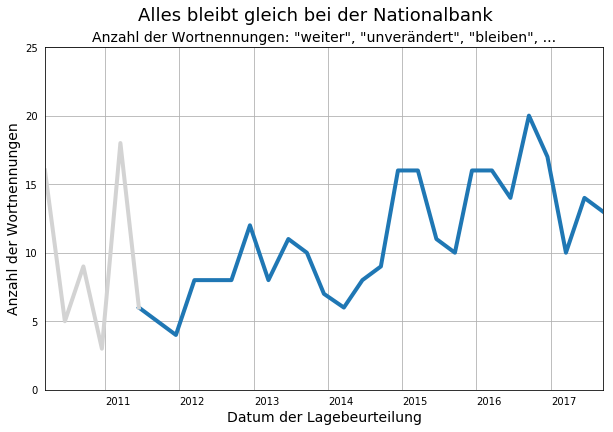

In [423]:
wordlist = ['weiter', 'weiterhin', 'unverändert', 'bleiben', 'bleibt', 'blieb', 'blieben', 'fortgesetzt', 'fortsetzen']
wordcounter = features_df[wordlist[0]].copy()
if len(wordlist) > 0:
    for word in wordlist[1:]:
        wordcounter += features_df[word].copy()

ax = wordcounter['2011-6':].plot(figsize=(10,7), linewidth=4)
ax = wordcounter['2010':'2011-6'].plot(figsize=(10,7), linewidth=4, color="lightgrey")
#ax.set_title("Rhetorischer Fokus auf Kontinuität", fontsize=20)
plt.suptitle("Alles bleibt gleich bei der Nationalbank", y=0.96, fontsize=18)
plt.title('Anzahl der Wortnennungen: "weiter", "unverändert", "bleiben", ...', fontsize=14)
ax.set_ylabel("Anzahl der Wortnennungen", fontsize=14)
ax.yaxis.set_ticks_position('none')
ax.set_ylim([0, 25])
ax.set_xlabel("Datum der Lagebeurteilung", fontsize=14)
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_ticks_position('none')
ax.legend().set_visible(False)
ax.grid(True)
plt.xticks(rotation=0)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
plt.savefig('web/img/continuity.pdf')

In [422]:
wordcounter['2011-6':]

date
2011-06-16     6
2011-09-15     5
2011-12-15     4
2012-03-15     8
2012-06-14     8
2012-09-13     8
2012-12-13    12
2013-03-14     8
2013-06-20    11
2013-09-19    10
2013-12-12     7
2014-03-20     6
2014-06-19     8
2014-09-18     9
2014-12-11    16
2015-03-19    16
2015-06-18    11
2015-09-17    10
2015-12-10    16
2016-03-17    16
2016-06-16    14
2016-09-15    20
2016-12-15    17
2017-03-16    10
2017-06-15    14
2017-09-14    13
Name: weiter, dtype: int64

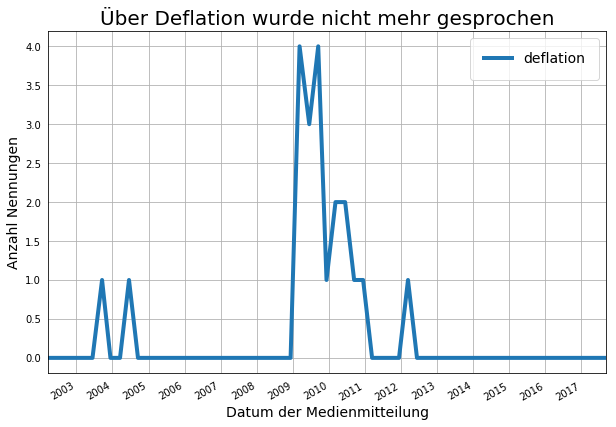

In [427]:
wordlist = ['deflation', 'deflationsgefahr', 'deflationsgefahren', 'deflationsrisiko']
wordcounter = features_df[wordlist[0]].copy()
if len(wordlist) > 0:
    for word in wordlist[1:]:
        wordcounter += features_df[word].copy()

ax = wordcounter.plot(figsize=(10,7), linewidth=4)
ax.set_title("Über Deflation wurde nicht mehr gesprochen", fontsize=20)
ax.set_ylabel("Anzahl Nennungen", fontsize=14)
ax.yaxis.set_ticks_position('none')
ax.set_xlabel("Datum der Medienmitteilung", fontsize=14)
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_ticks_position('none')
ax.legend(fontsize=14, borderpad=1)
ax.grid(True)

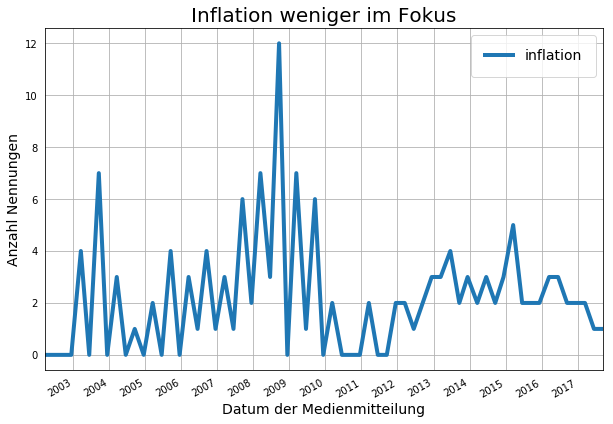

In [430]:
wordlist = ['inflation', 'inflationsgefahr', 'inflationsgefahren', 'inflationsrisiko']
wordcounter = features_df[wordlist[0]].copy()
if len(wordlist) > 0:
    for word in wordlist[1:]:
        wordcounter += features_df[word].copy()

ax = wordcounter.plot(figsize=(10,7), linewidth=4)
ax.set_title("Inflation weniger im Fokus", fontsize=20)
ax.set_ylabel("Anzahl Nennungen", fontsize=14)
ax.yaxis.set_ticks_position('none')
ax.set_xlabel("Datum der Medienmitteilung", fontsize=14)
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_ticks_position('none')
ax.legend(fontsize=14, borderpad=1)
ax.grid(True)

## Emotions

In [297]:
filepath = "emolex/NRC-Emotion-Lexicon-v0.92-InManyLanguages-German.xlsx"
emolex_df = pd.read_excel(filepath)
emolex_df.head(2)

,word,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,Aal,0,0,0,0,0,1,0,0,0,0
1,Aasfresser,0,1,0,0,0,0,0,0,0,0


In [298]:
#There are about 1500 duplicates
emolex_df.drop_duplicates(subset='word', inplace=True)
emolex_df.shape

(9629, 11)

In [309]:
emolex_df.sum()

word            AalAasfresserAbakusabbaabbauenAbbaustoffwechse...
positive                                                     1562
negative                                                     2195
anger                                                         810
anticipation                                                  548
disgust                                                       715
fear                                                          983
joy                                                           467
sadness                                                       787
surprise                                                      340
trust                                                         858
dtype: object

In [299]:
positive_words = emolex_df[emolex_df.positive == 1].word
negative_words = emolex_df[emolex_df.negative == 1].word
anger_words = emolex_df[emolex_df.anger == 1].word
anticipation_words = emolex_df[emolex_df.anticipation == 1].word
disgust_words = emolex_df[emolex_df.disgust == 1].word
fear_words = emolex_df[emolex_df.fear == 1].word
joy_words = emolex_df[emolex_df.joy == 1].word
sadness_words = emolex_df[emolex_df.sadness == 1].word
surprise_words = emolex_df[emolex_df.surprise == 1].word
trust_words = emolex_df[emolex_df.trust == 1].word

In [315]:
vec = TfidfVectorizer(vocabulary=emolex_df.word,
                      use_idf=False,
                      norm='l1')

matrix = vec.fit_transform(df.text)
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names(), index=df.index)
wordcount_df.head()

,Aal,Aasfresser,Abakus,abba,abbauen,Abbaustoffwechsel,abbilden,Abbildung,abbrechen,Abdeckung,...,Zyanid,zyklisch,Zyklon,Zyklus,Zylinder,zylindrisch,Zyniker,Zyste,zystische,Zytoplasma
date,,,,,,,,,,,,,,,,,,,,,
2002-03-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-06-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [316]:
df['positive'] = wordcount_df[positive_words].sum(axis=1)
df['negative'] = wordcount_df[negative_words].sum(axis=1)
df['anger'] = wordcount_df[anger_words].sum(axis=1)
df['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)
df['disgust'] = wordcount_df[disgust_words].sum(axis=1)
df['fear'] = wordcount_df[fear_words].sum(axis=1)
df['joy'] = wordcount_df[joy_words].sum(axis=1)
df['sadness'] = wordcount_df[sadness_words].sum(axis=1)
df['surprise'] = wordcount_df[surprise_words].sum(axis=1)
df['trust'] = wordcount_df[trust_words].sum(axis=1)

In [317]:
df['emotionality'] = df.anger + df.anticipation + df.disgust + df.fear + df.joy + df.sadness + df.surprise + df.trust

In [318]:
df['net_positive'] = df.positive - df.negative

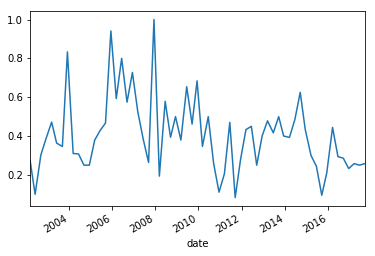

In [319]:
#general emotionality
fig, ax = plt.subplots()
df['emotionality'].plot(ax=ax)

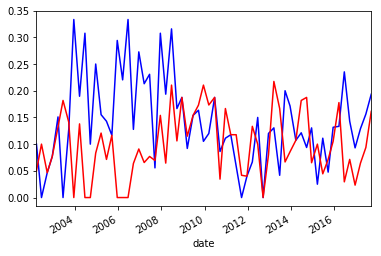

In [321]:
#positivity vs negativity
fig, ax = plt.subplots()

df.positive.plot(color='blue', ax=ax)
df.negative.plot(color='red', ax=ax)

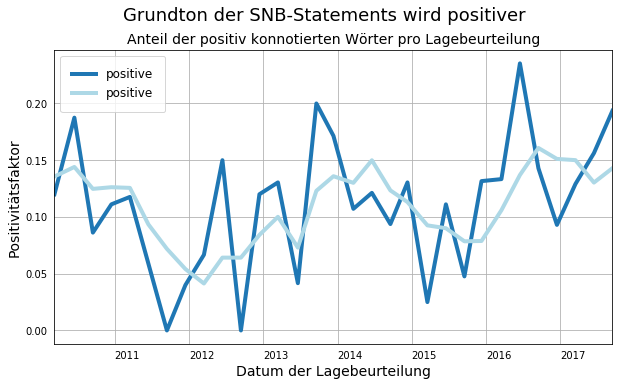

In [415]:
# positivity
fig, ax = plt.subplots(figsize=(10,6))
df['positive']['2010':].plot(ax=ax, linewidth=4)
df['positive'].rolling(4).mean()['2010':].plot(ax=ax, linewidth=4, color="lightblue")
#ax.set_title("Grundton der SNB wird positiver", fontsize=20)
plt.suptitle("Grundton der SNB-Statements wird positiver", y=0.98, fontsize=18)
plt.title("Anteil der positiv konnotierten Wörter pro Lagebeurteilung", fontsize=14)
ax.set_ylabel("Positivitätsfaktor", fontsize=14)
ax.yaxis.set_ticks_position('none')
ax.set_xlabel("Datum der Medienmitteilung", fontsize=14)
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_ticks_position('none')
#ax.legend().set_visible(False)
ax.legend(fontsize=12, borderpad=1, loc=2)
ax.grid(True)
plt.xticks(rotation=0)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
plt.savefig('web/img/positivity.pdf')

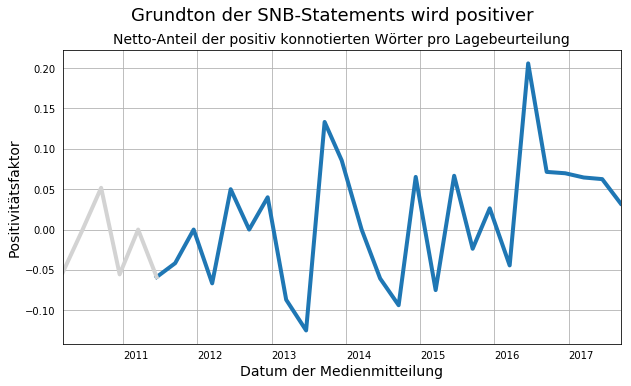

In [419]:
#net positivity
fig, ax = plt.subplots(figsize=(10,6))
df['net_positive']['2010':].plot(ax=ax, linewidth=4)
#ax.set_title("Grundton der SNB wird positiver", fontsize=20)
plt.suptitle("Grundton der SNB-Statements wird positiver", y=0.98, fontsize=18)
plt.title("Netto-Anteil der positiv konnotierten Wörter pro Lagebeurteilung", fontsize=14)
ax.set_ylabel("Positivitätsfaktor", fontsize=14)
ax.yaxis.set_ticks_position('none')
ax.set_xlabel("Datum der Medienmitteilung", fontsize=14)
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_ticks_position('none')
ax.legend().set_visible(False)
ax.grid(True)
plt.xticks(rotation=0)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
plt.savefig('web/img/positivity.pdf')

In [405]:
#The positive words most used by the SNB
wordcount_df['2010':][positive_words].sum().sort_values(ascending=False).head(20)

aufmerksam    0.496837
robust        0.240148
erheblich     0.233987
führen        0.226275
günstig       0.183864
sorgen        0.163664
fortsetzen    0.141444
beitragen     0.117771
stärken       0.108604
bescheiden    0.094758
unerwartet    0.092208
entwickeln    0.084484
verbessert    0.079222
gesichert     0.077206
stabil        0.070220
beleben       0.069048
voraus        0.063508
gut           0.058824
vorsichtig    0.057566
praktisch     0.055060
dtype: float64

In [330]:
#The negative words most used by the SNB
wordcount_df[negative_words].sum().sort_values(ascending=False).head(20)

behaftet           0.736374
gefährden          0.589039
gefährdet          0.385404
knapp              0.354276
schwach            0.315688
gedämpft           0.294416
verschlechtert     0.286233
negativ            0.247370
fiel               0.226042
verzögern          0.206803
dienen             0.188523
rückläufig         0.163661
notwendig          0.160276
ausgefallen        0.138284
ausgeschlossen     0.130580
bescheiden         0.120399
unerwartet         0.117591
verfolgen          0.101154
unsicher           0.096500
beeinträchtigen    0.089211
dtype: float64

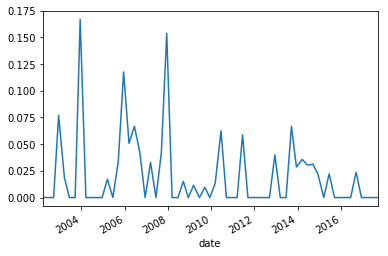

In [336]:
#surprise
fig, ax = plt.subplots()
df['surprise'].plot(ax=ax)

In [334]:
#The surprise words most used by the SNB
wordcount_df[surprise_words].sum().sort_values(ascending=False).head(20)

gut                0.637693
unerwartet         0.117591
beleben            0.085441
unterschiedlich    0.084720
erwarten           0.076957
verlieren          0.076923
offen              0.073908
verschwunden       0.062500
dynamisch          0.035165
höchste            0.016393
kompensieren       0.013333
verfrüht           0.009615
Geburtstag         0.000000
Freizeit           0.000000
frenetisch         0.000000
friedlich          0.000000
gaffen             0.000000
Geld               0.000000
gelegentlich       0.000000
Geschenk           0.000000
dtype: float64

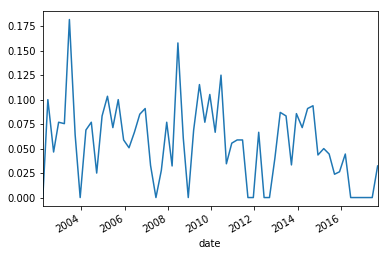

In [337]:
#fear
fig, ax = plt.subplots()
df['fear'].plot(ax=ax)

In [335]:
#The fear words most used by the SNB
wordcount_df[fear_words].sum().sort_values(ascending=False).head(20)

gefährden        0.589039
reagieren        0.536915
gefährdet        0.385404
knapp            0.354276
negativ          0.247370
verzögern        0.206803
verhindern       0.193002
unerwartet       0.117591
verfolgen        0.101154
unsicher         0.096500
vermeiden        0.085145
verlieren        0.076923
verschwunden     0.062500
endlos           0.062247
voll             0.062121
turbulent        0.052632
ausschliessen    0.052350
schwer           0.047021
dominieren       0.043277
schlechter       0.033333
dtype: float64

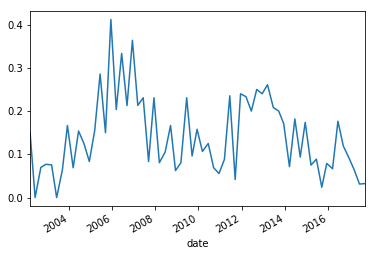

In [338]:
#anticipation
fig, ax = plt.subplots()
df['anticipation'].plot(ax=ax)

In [339]:
#The anticipation words most used by the SNB
wordcount_df[anticipation_words].sum().sort_values(ascending=False).head(20)

erwartet         3.491053
beabsichtigt     0.818238
günstig          0.774283
bereit           0.734389
gut              0.637693
gefährden        0.589039
allmählich       0.477449
fortsetzen       0.242023
wachsen          0.197021
entwickeln       0.179613
erhöhen          0.126674
unerwartet       0.117591
daraus           0.101153
überschreiten    0.086538
bestimmt         0.085488
erwarten         0.076957
offen            0.073908
zahlen           0.062236
verweilen        0.025000
lang             0.016393
dtype: float64

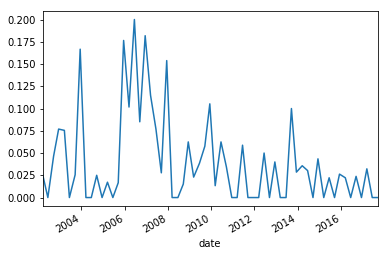

In [340]:
#joy
fig, ax = plt.subplots()
df['joy'].plot(ax=ax)

In [341]:
#The joy words most used by the SNB
wordcount_df[joy_words].sum().sort_values(ascending=False).head(20)

günstig          0.774283
gut              0.637693
wachsen          0.197021
grosszügig       0.149514
erhöhen          0.126674
unerwartet       0.117591
überschreiten    0.086538
beleben          0.085441
offen            0.073908
endlos           0.062247
zahlen           0.062236
erreichen        0.053911
begrüsst         0.050000
höchste          0.016393
kompensieren     0.013333
mieten           0.012821
Garten           0.000000
Fussball         0.000000
gefeiert         0.000000
Gelächter        0.000000
dtype: float64

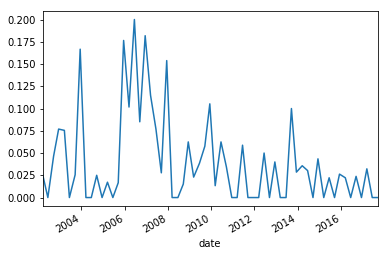

In [343]:
#joy
fig, ax = plt.subplots()
df['joy'].plot(ax=ax)

In [342]:
#The trust words most used by the SNB
wordcount_df[trust_words].sum().sort_values(ascending=False).head(20)

aufmerksam        0.685387
gut               0.637693
relativ           0.277817
gesichert         0.261114
fortsetzen        0.242023
wachsen           0.197021
dienen            0.188523
grosszügig        0.149514
stabil            0.129177
erhöhen           0.126674
vertrauen         0.097917
zusammen          0.088417
bestätigt         0.086413
beleben           0.085441
erwarten          0.076957
offen             0.073908
wichtig           0.071729
allgemein         0.065452
verantwortlich    0.063646
endlos            0.062247
dtype: float64